# Linear Model Fitting using empirical variogram
In classical geoestatistics it is frequent to use a sample-based variogram to fit a parametrised theoretical variogram. This method has proved to present biasses for the estimators of range, sill and shape. There are two reasons for this.
1. We are supposing that the observations are not random and the variogram is the true population variogram. 
2. The variogram is built on summary statistics (bin size) and the curve-fitness can vary depending on this size. 

Having said so, it is still a method used for estimating parameters and when the size of the data is big, being a good alternative to the likelihood methodology, a more robust optimization but computationally more complex. 

So first thing first, import the neessary modules. Depending on your machine this may change.
For the moment I work with this.

In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
sys.path.append('/apps/external_plugins/spystats/')
import django
django.setup()

## Use the ggplot style
plt.style.use('ggplot')


In [6]:
import pandas as pd
from statsmodels.regression import linear_model
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import tools
import HEC_runs.fit_fia_logbiomass_logspp_GLS as auxiliary

In [7]:
## File locations, change accordingly
empirical_data_path = "/RawDataCSV/idiv_share/FIA_Plots_Biomass_11092017.csv"
variogram_path = "/apps/external_plugins/spystats/HEC_runs/results/variogram/data_envelope.csv"


## Geographic extent 

In [11]:
minx = -130
maxx = -60
miny = 24
maxy = 50

### Auxiliary functions
    * Open file
    * Convert it to Pandas with Geometry (GeoPandas)
    * Reproject it to Lambert Conic Conformal
    * Calculate OLS and append residuals

In [13]:
data = auxiliary.initAnalysis(empirical_data_path=empirical_data_path,plotdata_path=plotdata_path, maxx=maxx,minx=minx,maxy=maxy,miny=miny)

INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Reprojecting to Alberts equal area
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Removing possible duplicates. 
 This avoids problems of Non Positive semidefinite
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Fitting OLS linear model: logBiomass ~ logSppN 
INFO:HEC_runs.fit_fia_logbiomass_logspp_GLS:Subselecting Region


### For testing, subselect the first 50 data points

In [81]:
test_data = data.loc[0:49,:]

## Now lets instantiate the variogram according to the results obtained in the cluster.
Remember:
    < Whittle Variogram : sill 0.340246718396, range 41188.0234423, nugget 0.329937603763, alpha1.12143687914 >

In [82]:
model = tools.WhittleVariogram(sill=0.340246718396,range_a=41188.0234423,nugget=0.329937603763,alpha=1.12143687914)

### Let's see the correlation

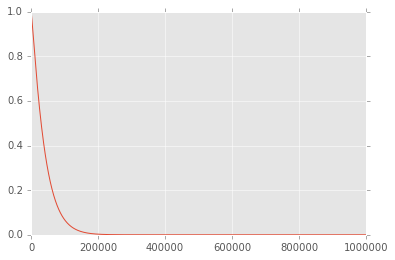

In [83]:
import numpy as np
X = np.linspace(0,1000000,1000)
plt.plot(X,model.corr_f(X))

In [84]:
vg = tools.Variogram(test_data,'residuals',model=model)
MM = vg.calculateCovarianceMatrix()

### Fit a GLS 

In [85]:
lmod = linear_model.GLS.from_formula(formula='logBiomass ~ logSppN',data=test_data,sigma=MM)

In [86]:
results = lmod.fit()

In [87]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.739
Model:                            GLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     135.8
Date:                Thu, 08 Feb 2018   Prob (F-statistic):           1.35e-15
Time:                        20:07:18   Log-Likelihood:                -37.860
No. Observations:                  50   AIC:                             79.72
Df Residuals:                      48   BIC:                             83.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.4659      0.159     53.276      0.000         8.146     8.785
logSppN        0.3405      0.097      3.508      0.001         0.145     0.536
==============================================================================
Omnibus:                        0.534   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.766   Jarque-Bera (JB):                0.661
Skew:                          -0.205   Prob(JB):                        0.719
Kurtosis:                       2.614   Cond. No.                         3.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
MM

array([[  3.40246718e-01,   7.31546364e-03,   8.15024713e-03, ...,
          1.84364060e-06,   1.59910176e-05,   4.09168002e-05],
       [  7.31546364e-03,   3.40246718e-01,   5.76166346e-03, ...,
          2.70041624e-06,   2.45467297e-05,   6.41058708e-05],
       [  8.15024713e-03,   5.76166346e-03,   3.40246718e-01, ...,
          1.24826472e-06,   1.09900133e-05,   2.84811261e-05],
       ..., 
       [  1.84364060e-06,   2.70041624e-06,   1.24826472e-06, ...,
          3.40246718e-01,   1.37447932e-03,   4.82794798e-04],
       [  1.59910176e-05,   2.45467297e-05,   1.09900133e-05, ...,
          1.37447932e-03,   3.40246718e-01,   4.49004133e-03],
       [  4.09168002e-05,   6.41058708e-05,   2.84811261e-05, ...,
          4.82794798e-04,   4.49004133e-03,   3.40246718e-01]])

In [89]:
DD = vg.distance_coordinates

In [90]:
correl_mat = vg.model.corr_f(DD)

In [91]:
correl_mat.tofile('/outputs/correl_matf50.csv',sep=",",format="%s")

In [92]:
MM.tofile('/outputs/covar_matf50.csv',sep=",",format="%s")

In [93]:
ls /outputs

HEC_outputs/                                pvalues_gls.csv*
correl_matf50.csv*                          rsqs.csv*
covar_matf50.csv*                           test_denmark.tif*
elevation1.tif*                             test_denmark.tif.aux.xml*
elevation1.tif.aux.xml*                     test_denmark_tm.tif*
fia_plots_reproject.csv*                    test_denmark_tm.tif.aux.xml*
gls_confidence_int.csv*                     test_graph.gml*
gp_sigma_rho.png*                           test_slope.tif*
logbiomas_logsppn_residuals_variogram.csv*  test_slope.tif.aux.xml*
n_obs.csv*                                  test_tree_figure_1.png*
outputstest_fabacea.tif*                    testooooooo.tif*
outputstest_fabacea.tif.aux.xml*            testooooooo.tif.tif*
params2_gls.csv*                            testooooooo.tif.tif.aux.xml*
params_gls.csv*                             tflow_outs/


In [94]:
MM.tofile?


In [95]:
lmodco = linear_model.GLS.from_formula(formula='logBiomass ~ logSppN',data=test_data,sigma=correl_mat)

In [96]:
res=lmodco.fit()

In [97]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.755
Model:                            GLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     147.6
Date:                Thu, 08 Feb 2018   Prob (F-statistic):           2.98e-16
Time:                        20:07:25   Log-Likelihood:                -51.743
No. Observations:                  50   AIC:                             107.5
Df Residuals:                      48   BIC:                             111.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.4012      0.673     12.488      0.000         7.049     9.754
logSppN        0.3233      0.103      3.125      0.003         0.115     0.531
==============================================================================
Omnibus:                        1.360   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                0.600
Skew:                           0.082   Prob(JB):                        0.741
Kurtosis:                       3.511   Cond. No.                         6.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
len(test_data)

51